In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

In [4]:
# Generate sample of size 200 from the mixture of two distributions
np.random.seed(42)
sample_size = 200
mu1, mu2 = 5, 10
std1, std2 = 1, 1
p1, p2 = 0.9, 0.1
sample = np.concatenate([
    np.random.normal(mu1, std1, int(p1 * sample_size)),
    np.random.normal(mu2, std2, int(p2 * sample_size))
])

In [5]:
# Compute the theoretical density
x = np.linspace(2, 12, 200)
f = p1 * norm.pdf(x, loc=mu1, scale=std1) + p2 * norm.pdf(x, loc=mu2, scale=std2)

In [6]:
# Estimate the density using kernel density estimator
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(sample[:, None])
log_dens = kde.score_samples(x[:, None])
fn = np.exp(log_dens)

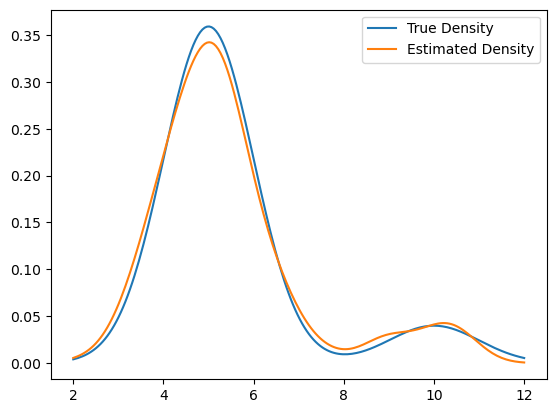

In [7]:
# Plot the theoretical density and estimated density
plt.plot(x, f, label='True Density')
plt.plot(x, fn, label='Estimated Density')
plt.legend()
plt.show()

In [8]:
# Compute the mean squared error
K = len(x)
error = ((f - fn) ** 2).mean()
print(f"Mean squared error: {error}")

Mean squared error: 0.0001000214692343242


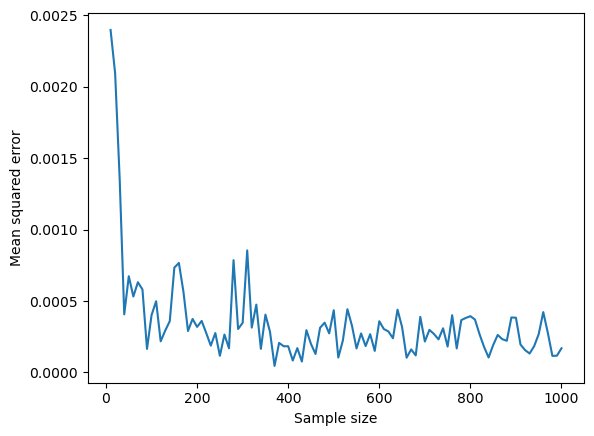

In [12]:
# Analyse the error for different sample sizes
sample_sizes = [10 * (i+1) for i in range(100)]
errors = []
for size in sample_sizes:
    sample = np.concatenate([
        np.random.normal(mu1, std1, int(p1 * size)),
        np.random.normal(mu2, std2, int(p2 * size))
    ])
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(sample[:, None])
    log_dens = kde.score_samples(x[:, None])
    fn = np.exp(log_dens)
    error = ((f - fn) ** 2).mean()
    errors.append(error)
plt.plot(sample_sizes, errors)
plt.xlabel('Sample size')
plt.ylabel('Mean squared error')
plt.show()

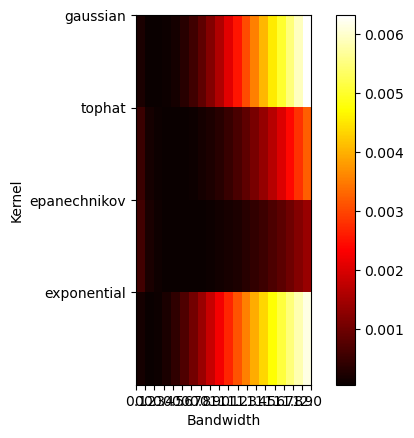

In [13]:
# Analyse the influence of different kernel functions and smoothing parameters
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential']
bandwidths = [0.1 * (i+1) for i in range(20)]
errors = np.zeros((len(kernels), len(bandwidths)))
for i, kernel in enumerate(kernels):
    for j, bandwidth in enumerate(bandwidths):
        kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(sample[:, None])
        log_dens = kde.score_samples(x[:, None])
        fn = np.exp(log_dens)
        error = ((f - fn) ** 2).mean()
        errors[i, j] = error
plt.imshow(errors, cmap='hot', interpolation='nearest', extent=[bandwidths[0], bandwidths[-1], len(kernels), 0])
plt.xticks(bandwidths)
plt.yticks(range(len(kernels)), kernels)
plt.xlabel('Bandwidth')
plt.ylabel('Kernel')
plt.colorbar()
plt.show()

In [16]:
data = load_breast_cancer()
X = data.data
y = data.target

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Naive Bayes classifier with kernel density estimator
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X_train[y_train == 0])
log_dens_0 = kde.score_samples(X_test)
kde.fit(X_train[y_train == 1])
log_dens_1 = kde.score_samples(X_test)
y_pred_kde = (log_dens_1 > log_dens_0).astype(int)

# Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

# Naive Bayes classifier with discretization of quantitative features
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discretizer.fit(X_train)
X_train_discretized = discretizer.transform(X_train)
X_test_discretized = discretizer.transform(X_test)
gnb_discretized = GaussianNB()
gnb_discretized.fit(X_train_discretized, y_train)
y_pred_discretized = gnb_discretized.predict(X_test_discretized)

# LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)


In [19]:
acc_kde = accuracy_score(y_test, y_pred_kde)
acc_gnb = accuracy_score(y_test, y_pred_gnb)
acc_discretized = accuracy_score(y_test, y_pred_discretized)
acc_lda = accuracy_score(y_test, y_pred_lda)

print(f"Accuracy of Naive Bayes classifier with kernel density estimator: {acc_kde}")
print(f"Accuracy of Gaussian Naive Bayes classifier: {acc_gnb}")
print(f"Accuracy of Naive Bayes classifier with discretization of quantitative features: {acc_discretized}")
print(f"Accuracy of LDA classifier: {acc_lda}")


Accuracy of Naive Bayes classifier with kernel density estimator: 0.9298245614035088
Accuracy of Gaussian Naive Bayes classifier: 0.9415204678362573
Accuracy of Naive Bayes classifier with discretization of quantitative features: 0.9415204678362573
Accuracy of LDA classifier: 0.9532163742690059
